# K-means Cluster Heatmaps

In [1]:
import pandas as pd

expression = pd.read_csv("expression.txt", sep="\t")
expression = expression.set_index("Hugo_Symbol")
expression = expression.drop("Entrez_Gene_Id", axis=1)
# print(expression.head())

In [2]:
# patients = pd.read_csv("patient_bchm_recurr_cohorts.csv")
# print(patients.head())
# print()
# bchm_early_pts = patients[patients["Days to Bchm Recurr"]<100]
# bchm_late_pts = patients[patients["Days to Bchm Recurr"]>100]
# bchem_early_ids = bchm_early_pts["Patient (Firehose)"].to_list()
# bchem_late_ids = bchm_late_pts["Patient (Firehose)"].to_list()
# print(bchem_early_ids)
# print()
# print(bchem_late_ids)

In [3]:
patients = pd.read_csv("bchem_cohorts.csv")
print(patients.head())
print()
bchem_c1 = patients[patients["BCHEM_COHORT"]==1]
bchem_c2 = patients[patients["BCHEM_COHORT"]==2]
bchem_c3 = patients[patients["BCHEM_COHORT"]==3]
bchem_c4 = patients[patients["BCHEM_COHORT"]==4]

bchem_c1_ids = bchem_c1["PATIENT_ID"].to_list()
bchem_c2_ids = bchem_c2["PATIENT_ID"].to_list()
bchem_c3_ids = bchem_c3["PATIENT_ID"].to_list()
bchem_c4_ids = bchem_c4["PATIENT_ID"].to_list()
# print(bchem_c1_ids)
# print(bchem_c2_ids)
# print(bchem_c3_ids)
# print(bchem_c4_ids)

     PATIENT_ID  DAYS_TO_BIOCHEMICAL_RECURRENCE_FIRST  BCHEM_COHORT
0  TCGA-ZG-A9L9                                    51             1
1  TCGA-EJ-A65F                                    75             1
2  TCGA-YL-A9WJ                                    76             1
3  TCGA-EJ-5504                                    77             1
4  TCGA-J4-AATZ                                    79             1



In [4]:
# early_bchem = expression[expression.columns.intersection(bchem_early_ids)]
# early_bchem = early_bchem.dropna(axis=0)
# late_bchem = expression[expression.columns.intersection(bchem_late_ids)]
# late_bchem = late_bchem.dropna(axis=0)
# print(early_bchem.head())
# print()
# print(late_bchem.head())

In [5]:
c1_bchem = expression[expression.columns.intersection(bchem_c1_ids)]
c1_bchem = c1_bchem.dropna(axis=0)

c2_bchem = expression[expression.columns.intersection(bchem_c2_ids)]
c2_bchem = c2_bchem.dropna(axis=0)

c3_bchem = expression[expression.columns.intersection(bchem_c3_ids)]
c3_bchem = c3_bchem.dropna(axis=0)

c4_bchem = expression[expression.columns.intersection(bchem_c4_ids)]
c4_bchem = c4_bchem.dropna(axis=0)

# print(c1_bchem.head())
# print()
# print(c2_bchem.head())
# print()
# print(c3_bchem.head())
# print()
# print(c4_bchem.head())

In [51]:
# outliers adjustment code using IQR method (can't use mean method because of large outliers)

def replace_row_outliers_with_median(df: pd.DataFrame, threshold: float = 1):
    df_clean = df.copy()
    for index, row in df.iterrows():
        Q1 = row.quantile(0.25)
        Q3 = row.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        median = row.median()
        outliers = (row < lower_bound) | (row > upper_bound)
        # Now update only the outlier *values* in the row
        for col in df.columns:
            if row[col] < lower_bound or row[col] > upper_bound:
                df_clean.at[index, col] = median
    return df_clean

adjusted_c1 = replace_row_outliers_with_median(c1_bchem)
adjusted_c2 = replace_row_outliers_with_median(c2_bchem)
adjusted_c3 = replace_row_outliers_with_median(c3_bchem)
adjusted_c4 = replace_row_outliers_with_median(c4_bchem)

# print(adjusted_c1.head())


In [52]:
# print(c1_bchem.loc["CPLX2"])
# sns.barplot(c1_bchem.loc["CPLX2"])
# print(adjusted_c1.loc["CPLX2"])
# sns.barplot(adjusted_c1.loc["CPLX2"])

In [53]:
adjusted_c1["c1 Average"] = adjusted_c1.mean(axis=1)
# print(early_bchem.head())
adjusted_c2["c2 Average"] = adjusted_c2.mean(axis=1)
# print(late_bchem.head())
adjusted_c3["c3 Average"] = adjusted_c3.mean(axis=1)
adjusted_c4["c4 Average"] = adjusted_c4.mean(axis=1)

expression = pd.DataFrame()
expression["c1 Average"] = adjusted_c1[["c1 Average"]] 
expression["c2 Average"] = adjusted_c2[["c2 Average"]] 
expression["c3 Average"] = adjusted_c3[["c3 Average"]] 
expression["c4 Average"] = adjusted_c4[["c4 Average"]] 
# combined_df = append(late_bchem[["Late Average"]]
print(expression.head())

             c1 Average  c2 Average  c3 Average  c4 Average
Hugo_Symbol                                                
UBE2Q2P2       0.037578   -0.246106    0.743353    0.428489
SSX9          -0.047400   -0.047400   -0.047400   -0.047400
EZHIP         -0.147017   -0.343982   -0.028112    0.001308
EFCAB8         0.004756   -0.190600   -0.078253    0.064161
SDR16C6P      -0.183900   -0.183900   -0.183900   -0.183900


In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

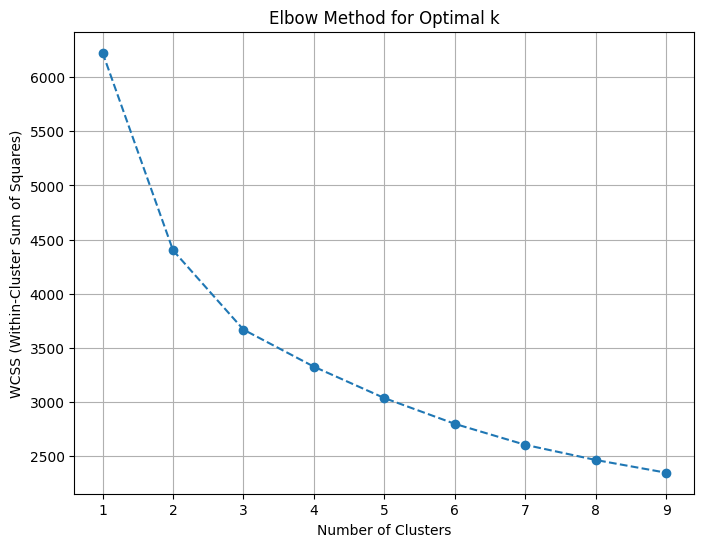

In [55]:
data = expression

# List to store WCSS for each number of clusters
wcss = []

# Loop over possible values of k (number of clusters)
for num_clusters in range(1, 10):  # You can adjust the range based on your data
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)  # WCSS is stored in inertia_

# Plot the Elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(np.arange(1, 10))
plt.grid(True)
plt.show()

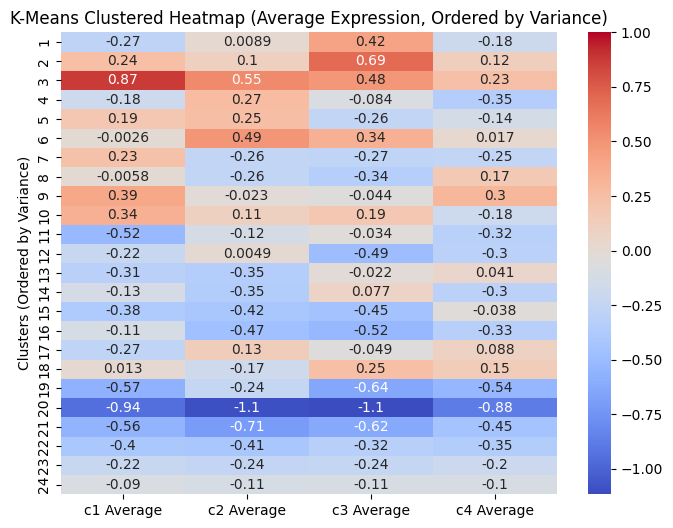

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Filter only columns containing "Average" BEFORE clustering
average_data = data.loc[:, data.columns.str.contains("Average")].copy()

# Number of clusters
num_clusters = 24

# Run KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=40)
clusters = kmeans.fit_predict(average_data)

# Add cluster labels to the filtered data
average_data["Cluster"] = clusters

# Group by cluster and compute mean expression per cluster
clustered_data = average_data.groupby("Cluster").mean()

# Compute variance across columns for each cluster
cluster_variances = clustered_data.var(axis=1)

# Sort clusters by decreasing variance
sorted_clusters = cluster_variances.sort_values(ascending=False).index

# Create mapping from old cluster label to new label (ordered by variance)
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters, start=1)}

# Apply new cluster label mapping
average_data["Cluster"] = average_data["Cluster"].map(cluster_mapping)

# Recompute cluster means using remapped cluster labels
clustered_data = average_data.groupby("Cluster").mean()

# Sort clustered_data rows by new cluster label (which is already ordered by variance)
clustered_data = clustered_data.loc[sorted(clustered_data.index)]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(clustered_data, cmap="coolwarm", xticklabels=True, yticklabels=True, annot=True, vmax=1)

plt.title("K-Means Clustered Heatmap (Average Expression, Ordered by Variance)")
plt.ylabel("Clusters (Ordered by Variance)")
plt.show()


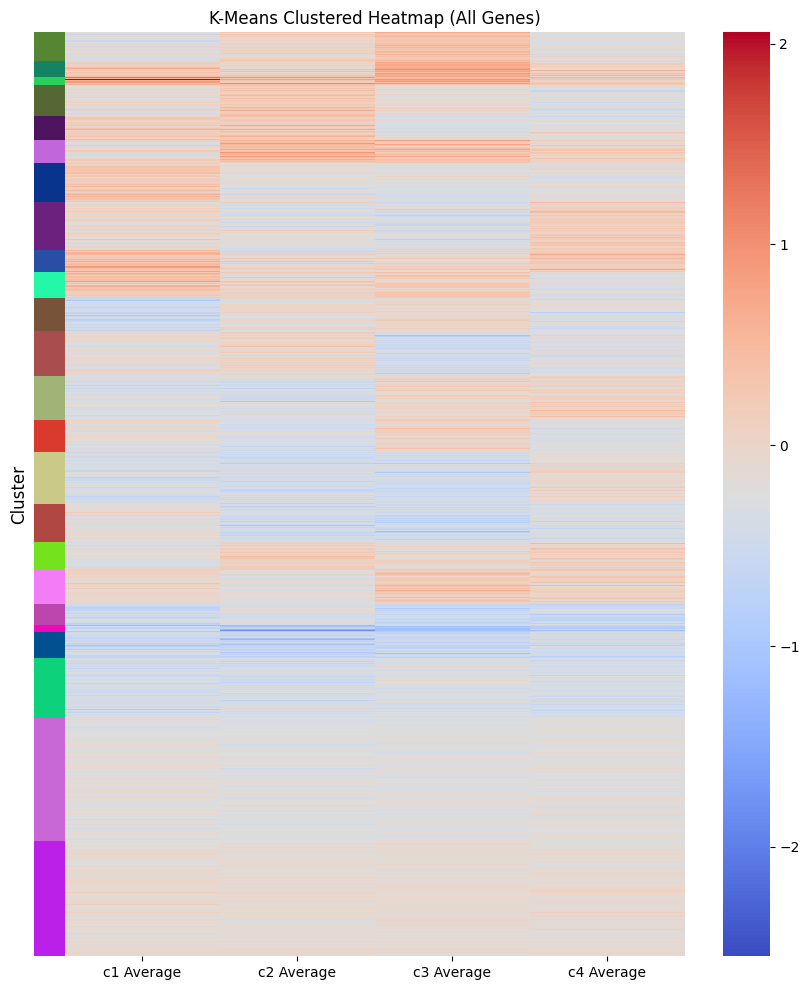

In [79]:
from matplotlib.colors import ListedColormap

# Reorder full dataset by new cluster labels
data_sorted = average_data.sort_values(by="Cluster")

# Get the number of unique clusters
num_clusters = data_sorted["Cluster"].nunique()

# Generate a random colormap for clusters
random_colors = np.random.rand(num_clusters, 3)  # Random RGB colors
cluster_cmap = ListedColormap(random_colors)  # Create colormap

# Create a figure for both heatmaps
plt.figure(figsize=(10, 12))

# Create a main heatmap for the data (without the cluster column)
sns.heatmap(data_sorted.drop(columns=["Cluster"]), cmap="coolwarm", xticklabels=True, yticklabels=False)

# Create an inset axis for the color bar (cluster labels)
cbar_ax = plt.gca().inset_axes([-0.05, 0, 0.05, 1])  # Thin vertical color bar on the left side

# Plot the cluster labels as a heatmap on the left side using the random colormap
sns.heatmap(data_sorted[['Cluster']], cmap=cluster_cmap, cbar=False, xticklabels=False, yticklabels=False, ax=cbar_ax)

# Add y-axis label for the inset color bar
cbar_ax.set_ylabel('Cluster', fontsize=12)

# Remove any index column label (this is likely where "Unnamed: 0" comes from)
plt.gca().set_ylabel("")  # This removes the y-axis label on the second heatmap

# Adjust layout and finalize the plot
plt.title("K-Means Clustered Heatmap (All Genes)")
plt.show()

In [80]:
# Getting rid of semi-colons for Enrichr

list_of_clusters = []
for cluster_num in range(1, num_clusters + 1): 
    genes_in_cluster = average_data[average_data["Cluster"] == cluster_num].index.to_list()
    list_of_clusters.append(genes_in_cluster)
    
j = 1
for cluster in list_of_clusters:
    i = 0
    while i < len(cluster):
        if ';' in cluster[i]:
            split_genes = cluster[i].split(';')
            cluster[i:i+1] = split_genes  # Replace the original gene with the split genes
            i += len(split_genes) - 1  # Skip over the new elements added
        i+=1
#     print(f"Cluster {j}:")
#     print(cluster)
    print(f"Cluster {j} length: " + str(len(cluster)))
    j+=1
    

Cluster 1 length: 565
Cluster 2 length: 318
Cluster 3 length: 173
Cluster 4 length: 608
Cluster 5 length: 486
Cluster 6 length: 443
Cluster 7 length: 784
Cluster 8 length: 955
Cluster 9 length: 449
Cluster 10 length: 518
Cluster 11 length: 657
Cluster 12 length: 881
Cluster 13 length: 874
Cluster 14 length: 650
Cluster 15 length: 1034
Cluster 16 length: 744
Cluster 17 length: 560
Cluster 18 length: 693
Cluster 19 length: 416
Cluster 20 length: 142
Cluster 21 length: 510
Cluster 22 length: 1193
Cluster 23 length: 2439
Cluster 24 length: 2305


# Over-representation Analysis

In [59]:
import gseapy as gp
# human = gp.get_library_name(organism='Human')

# for geneset_library in human:
#     if "hallmark" in geneset_library.lower():
#         print(geneset_library)

# library = gp.get_library(name="GO_Biological_Process_2025", organism="Human")
# print(library.keys())

In [82]:
from IPython.display import display, HTML

cluster = list_of_clusters[2]
print(f"Cluster size: {len(cluster)}")
print()
print(cluster)

enr = gp.enrich(gene_list=cluster, # or gene_list=glist
                 gene_sets=["data/bp_2024.gmt", "data/cc_2024.gmt", "data/mf_2024.gmt", "data/hallmark_2024.gmt", "data/onc_2024.gmt", "data/im_2024.gmt"], # kegg is a dict object
                 background=data.index.to_list(),
                 outdir=None,
                 verbose=False)

display(HTML(enr.results.loc[enr.results["Adjusted P-value"] < 0.05].sort_values(by='Adjusted P-value').to_html()))

Cluster size: 173

['ABCC5', 'ANKRD13D', 'ANKRD46', 'AP1S1', 'ARHGAP39', 'ARMC1', 'ATP6V1C1', 'AURKA', 'AZIN1', 'BPGM', 'LRRC75A', 'XXYLT1', 'FAM220A', 'C8orf33', 'NDUFAF6', 'C8orf76', 'FAM219A', 'CABLES2', 'CBX1', 'CDCA4', 'CDK16', 'CHCHD3', 'CHMP4C', 'CHRAC1', 'CIT', 'CLCN2', 'CLDN15', 'CLK2', 'COPS5', 'CRTC2', 'CSPP1', 'CUL1', 'DBN1', 'DCAF13', 'DERL1', 'DSCC1', 'DVL3', 'ELK1', 'ENSA', 'ENY2', 'ESRP1', 'EZH2', 'ZC2HC1A', 'FAM189B', 'RMDN1', 'FAM83H', 'FAM91A1', 'FANCC', 'FBXL6', 'FBXO43', 'GIGYF1', 'GMPS', 'GNA12', 'GRINA', 'GTPBP2', 'HDAC7', 'HSF1', 'IAH1', 'INPP5E', 'INTS8', 'IPO9', 'ISLR2', 'KCNK9', 'CEP170B', 'KIAA1429', 'LIMK1', 'LRCH4', 'LRRC14', 'LYSMD1', 'MAL2', 'MAP4K4', 'MARK4', 'MCM7', 'MGAT4B', 'MTBP', 'MTDH', 'MTFR1', 'MUS81', 'NAA40', 'NCAPG2', 'TONSL', 'NPIPA1', 'NSMCE2', 'NUDCD1', 'NUPL2', 'OSGIN2', 'OTUD6B', 'PABPC1', 'PDZD7', 'PHF20L1', 'PHTF2', 'PLCB3', 'PLOD3', 'PLXNA3', 'POLD3', 'POLR2K', 'PPP2R5B', 'PRC1', 'PSMC2', 'PSMD2', 'PTK2', 'PTPN12', 'RAB11FIP3', 'RAD21

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
4152,im_2024.gmt,GSE18804_BRAIN_VS_COLON_TUMORAL_MACROPHAGE_DN,21/175,1.656740e-17,6.988128e-14,16.483219,636.896675,ZNF696;STK3;INTS8;NUDCD1;SCRIB;TRMT12;DCAF13;NSMCE2;C8orf76;RAD21;FAM91A1;NDUFAF6;SLC25A32;YWHAZ;CHMP4C;UBR5;DSCC1;RNF139;COPS5;PHF20L1;PABPC1
6531,im_2024.gmt,GSE45365_CTRL_VS_MCMV_INFECTION_NK_CELL_DN,20/167,1.051487e-16,2.217586e-13,16.361519,601.959216,UTP23;SQLE;INTS8;SCRIB;TRMT12;DCAF13;NSMCE2;PTK2;C8orf76;ARMC1;RAD21;NDUFAF6;TERF1;CHMP4C;ENY2;DSCC1;RNF139;COPS5;DERL1;PHF20L1
6527,im_2024.gmt,GSE45365_CD8A_DC_VS_CD11B_DC_IFNAR_KO_DN,15/172,8.395659e-11,1.180430e-07,11.213770,260.167551,RNF139;DCAF13;ZNF16;TATDN1;TAF2;NSMCE2;PTK2;PHF20L1;TBC1D31;RAD21;CHMP4C;NDUFAF6;FAM91A1;ZFAND1;ENSA
190,bp_2024.gmt,GOBP_CELL_CYCLE,37/1518,6.028536e-08,1.279858e-04,3.103570,51.594302,FBXO43;SUN1;RAB11FIP3;RAD54B;MTBP;WRAP73;RHEB;SCRIB;ENSA;MARK4;PPP2R5B;EZH2;CABLES2;CSPP1;DCAF13;ZNF16;NSMCE2;RAD21;HSF1;YEATS2;CUL1;AURKA;TAF2;TERF1;TPX2;OSGIN2;CHMP4C;DSCC1;MUS81;COPS5;TACC3;RRM2B;CIT;RMDN1;NCAPG2;PRC1;CDK16
2885,hallmark_2024.gmt,HALLMARK_G2M_CHECKPOINT,10/184,9.783229e-06,3.228465e-04,6.640441,76.596426,CUL1;SQLE;AURKA;TACC3;TPX2;CBX1;FANCC;RAD21;PRC1;EZH2
1046,bp_2024.gmt,GOBP_ORGANELLE_FISSION,17/460,1.691527e-06,9.245102e-04,4.481542,59.559152,FBXO43;MUS81;SUN1;RAD54B;AURKA;MTBP;NSMCE2;DCAF13;TERF1;RMDN1;TPX2;RAD21;NCAPG2;CHMP4C;WRAP73;MTFR1;PRC1
1521,bp_2024.gmt,GOBP_REGULATION_OF_CELL_CYCLE,27/1016,9.690518e-07,9.245102e-04,3.268336,45.256482,FBXO43;RAB11FIP3;MTBP;RHEB;SCRIB;MARK4;PPP2R5B;EZH2;CABLES2;CSPP1;ZNF16;NSMCE2;RAD21;HSF1;YEATS2;AURKA;TERF1;TPX2;CHMP4C;MUS81;COPS5;TACC3;RRM2B;CIT;NCAPG2;PRC1;CDK16
196,bp_2024.gmt,GOBP_CELL_CYCLE_PROCESS,29/1179,1.741894e-06,9.245102e-04,3.028569,40.160452,FBXO43;SUN1;RAD54B;MTBP;WRAP73;ENSA;MARK4;PPP2R5B;EZH2;CSPP1;DCAF13;ZNF16;NSMCE2;RAD21;CUL1;AURKA;TAF2;TERF1;TPX2;CHMP4C;DSCC1;MUS81;TACC3;RRM2B;CIT;RMDN1;NCAPG2;PRC1;RAB11FIP3
1525,bp_2024.gmt,GOBP_REGULATION_OF_CELL_CYCLE_PROCESS,20/679,6.372070e-06,2.052818e-03,3.555643,42.538236,FBXO43;MTBP;PPP2R5B;MARK4;EZH2;CSPP1;ZNF16;NSMCE2;RAD21;AURKA;TERF1;TPX2;CHMP4C;MUS81;TACC3;RRM2B;CIT;NCAPG2;PRC1;RAB11FIP3
999,bp_2024.gmt,GOBP_NUCLEAR_CHROMOSOME_SEGREGATION,13/299,5.270679e-06,2.052818e-03,5.264422,63.980375,SUN1;DCAF13;AURKA;NSMCE2;TERF1;RMDN1;TACC3;TPX2;RAD21;CHMP4C;WRAP73;NCAPG2;PRC1


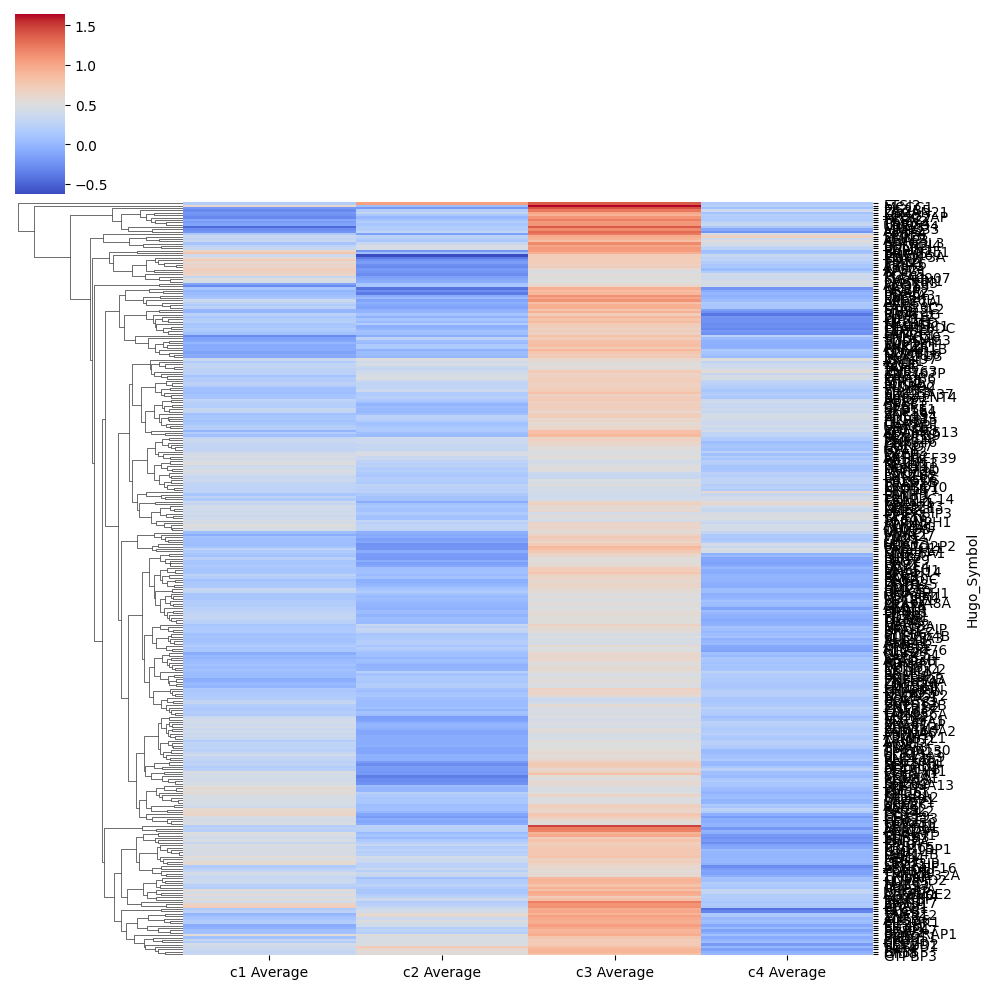

In [61]:
sns.clustermap(data_sorted.loc[cluster].drop(columns=["Cluster"]), cmap="coolwarm", xticklabels=True, yticklabels=True, annot=False, col_cluster = False)


In [62]:
adjusted_c1.columns = ["1"] * len(adjusted_c1.columns)
adjusted_c2.columns = ["2"] * len(adjusted_c2.columns)
adjusted_c3.columns = ["3"] * len(adjusted_c3.columns)
adjusted_c4.columns = ["4"] * len(adjusted_c4.columns)
print(adjusted_c1.head())

                  1       1       1       1       1       1       1       1  \
Hugo_Symbol                                                                   
UBE2Q2P2    -0.5443  0.0453 -0.0651  0.9005  0.0184  0.0184 -0.7704 -0.6849   
SSX9        -0.0474 -0.0474 -0.0474 -0.0474 -0.0474 -0.0474 -0.0474 -0.0474   
EZHIP       -0.0684 -0.5459 -0.2836 -0.7616  0.7517 -0.7616 -0.3635 -0.1523   
EFCAB8      -0.4290 -0.1805 -0.4290 -0.2365 -0.2111  0.6982  0.2590 -0.4290   
SDR16C6P    -0.1839 -0.1839 -0.1839 -0.1839 -0.1839 -0.1839 -0.1839 -0.1839   

                  1        1       1        1       1       1       1       1  \
Hugo_Symbol                                                                     
UBE2Q2P2     0.7732  0.01090  0.5965 -0.22340  0.0259  0.5946 -0.0795  0.9356   
SSX9        -0.0474 -0.04740 -0.0474 -0.04740 -0.0474 -0.0474 -0.0474 -0.0474   
EZHIP       -0.3227 -0.10640  0.7552 -0.76160 -0.1523 -0.0951 -0.3083 -0.1982   
EFCAB8       0.3296  0.03925  0.4448  0.0

/home/srifai/HussainLab/GNN_Cancer/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


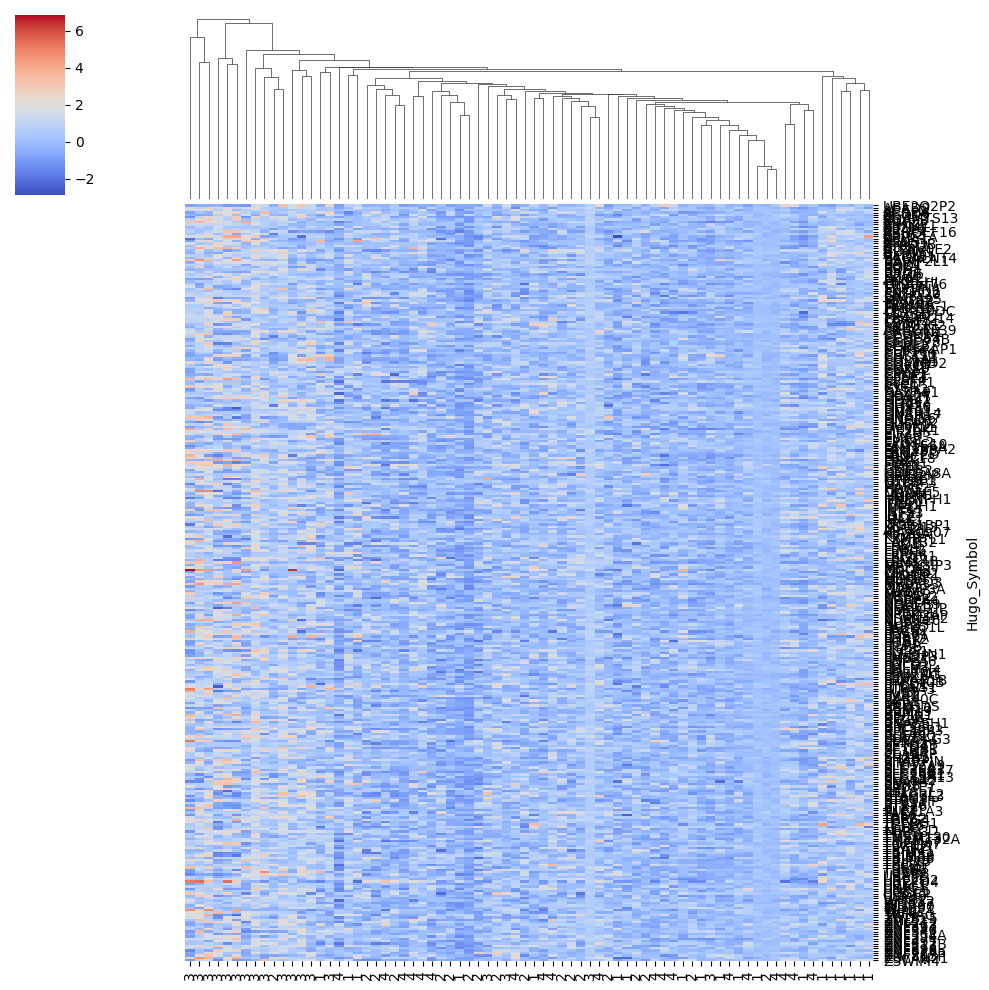

In [63]:
parent_bchem = pd.DataFrame()
parent_bchem = pd.concat([adjusted_c1, adjusted_c2, adjusted_c3, adjusted_c4], axis = 1)
drop_cols = [col for col in parent_bchem.columns if "Average" in col]
parent_bchem = parent_bchem.drop(columns = drop_cols, axis=1)
# print(parent_bchem.head())
sns.clustermap(parent_bchem.loc[cluster], cmap="coolwarm", xticklabels=True, yticklabels=True, annot=False, row_cluster=False)

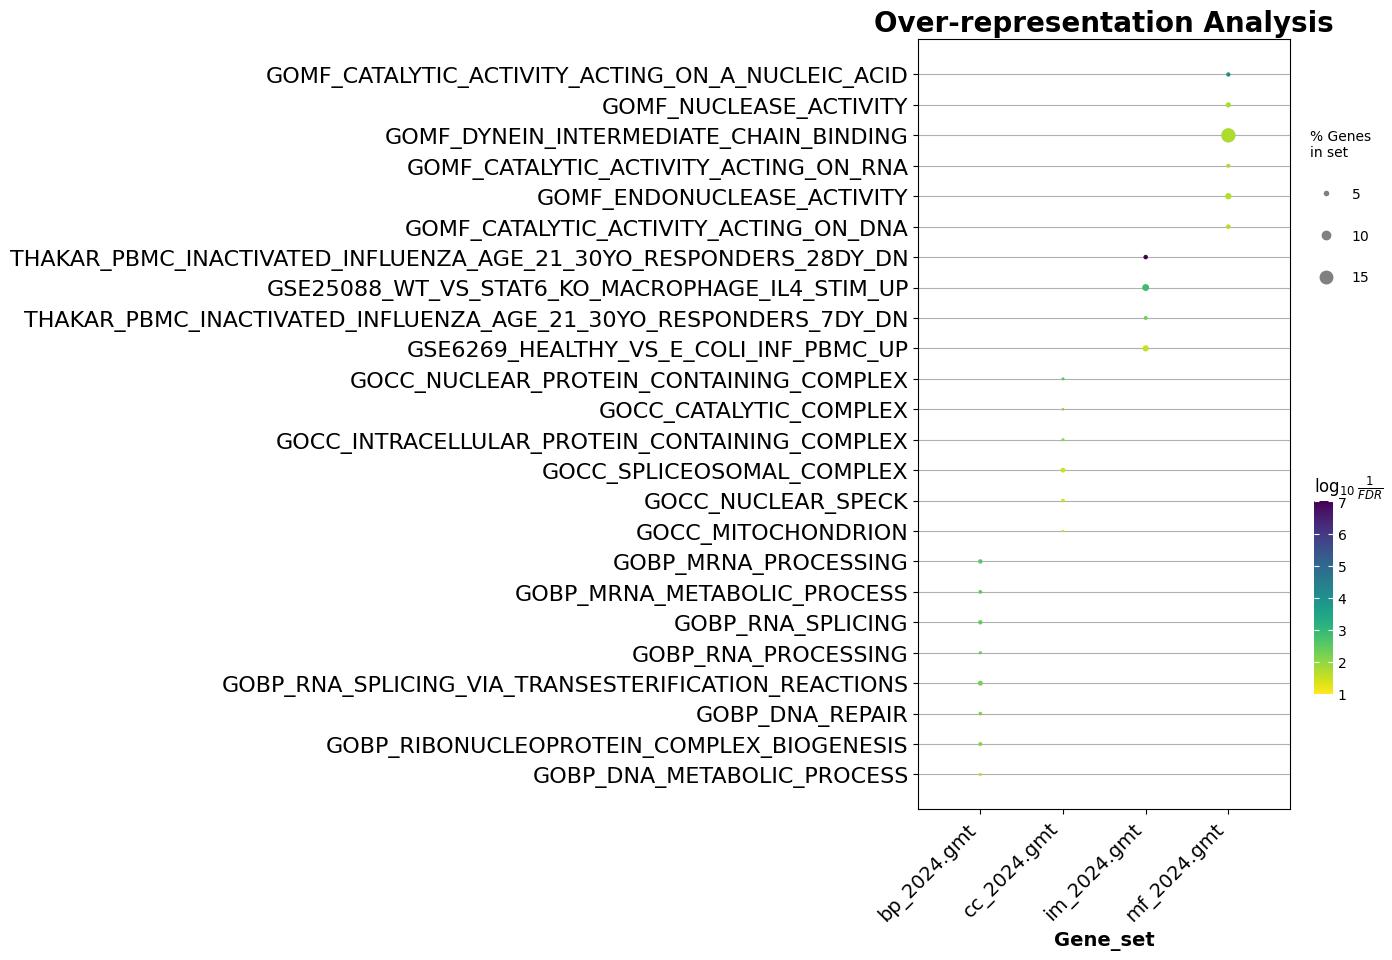

In [64]:
from gseapy import barplot, dotplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              figsize=(6,10),
              title = "Over-representation Analysis",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='o',
             )

In [65]:
parent_bchem_T = parent_bchem.loc[cluster].T
print(parent_bchem_T.head())
# # Remove columns with repeated names
# total_data = data.loc[:, ~parent_bchem.columns.duplicated()]

# # Drop non-numeric columns (assuming the first 3 columns are metadata)
# gene_expression = total_data.iloc[:, 0:]  # Exclude the label column

# Convert to numpy array
parent_bchem_T_vals = parent_bchem_T.values

print(parent_bchem_T_vals)

Hugo_Symbol  UBE2Q2P2    ACAD9   ACAP3   ACBD6    ACOT9  ADAMTS13    AGAP3  \
1             -0.5443 -0.64640 -1.2585 -0.6980 -0.67170   -1.1338  0.26225   
1              0.0453  0.23065  1.0092 -0.4956 -1.49340   -0.6641  0.87030   
1             -0.0651 -1.00650 -0.4758 -0.2009 -0.21600   -0.2266 -0.35720   
1              0.9005  0.23065 -0.4893  1.2017 -0.12245    1.2959 -0.10550   
1              0.0184 -0.72080  0.1508 -0.6551  0.09650   -0.1603  0.27780   

Hugo_Symbol   AIMP2  ANKZF1   AP2M1  ...    ZNF3  ZNF497  ZNF512B  ZNF517  \
1           -0.2916 -1.1004 -0.3108  ...  0.1319 -0.7359  -1.2962 -1.1680   
1           -0.4989  0.0206  0.2404  ...  0.8024 -0.8360   0.6074  0.0123   
1           -1.1391 -0.3590 -1.3880  ...  0.4378  0.1977   1.1501  0.1707   
1           -0.2843 -0.3892 -0.9181  ... -0.0194  0.2307   0.6074  2.0592   
1           -1.1611 -0.3339 -0.2818  ... -1.1760 -0.2566   0.5977  0.9481   

Hugo_Symbol  ZNF598   ZNF628  ZNF767P  ZNF815P  ZSCAN21  ZSWIM4  
1 

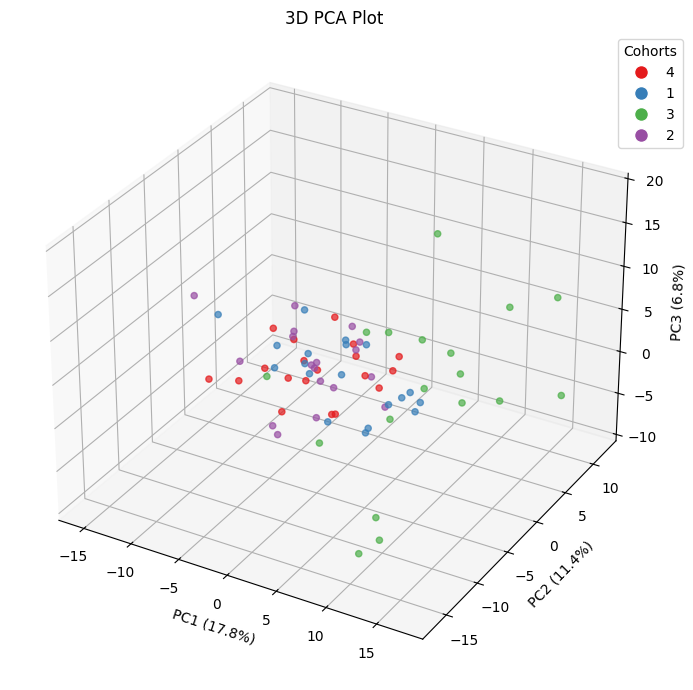

In [66]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=3)
gene_expression_pca = pca.fit_transform(parent_bchem_T_vals)

# Get % variance explained
explained_var = pca.explained_variance_ratio_ * 100  # convert to percent

# Get cohort labels
cohorts = parent_bchem.columns
unique_labels = list(set(cohorts))
color_map = {label: color for label, color in zip(unique_labels, plt.cm.Set1.colors)}
colors = cohorts.map(color_map)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot PCA
scatter = ax.scatter(
    gene_expression_pca[:, 0],
    gene_expression_pca[:, 1],
    gene_expression_pca[:, 2],
    c=colors, alpha=0.7
)

ax.set_xlabel(f'PC1 ({explained_var[0]:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_var[1]:.1f}%)')
ax.set_zlabel(f'PC3 ({explained_var[2]:.1f}%)')
ax.set_title('3D PCA Plot')

# Legend
legend_patches = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
    for label, color in color_map.items()
]
ax.legend(handles=legend_patches, title='Cohorts', loc='best', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()


/tmp/ipykernel_952/2152845138.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("Set1", len(unique_labels))


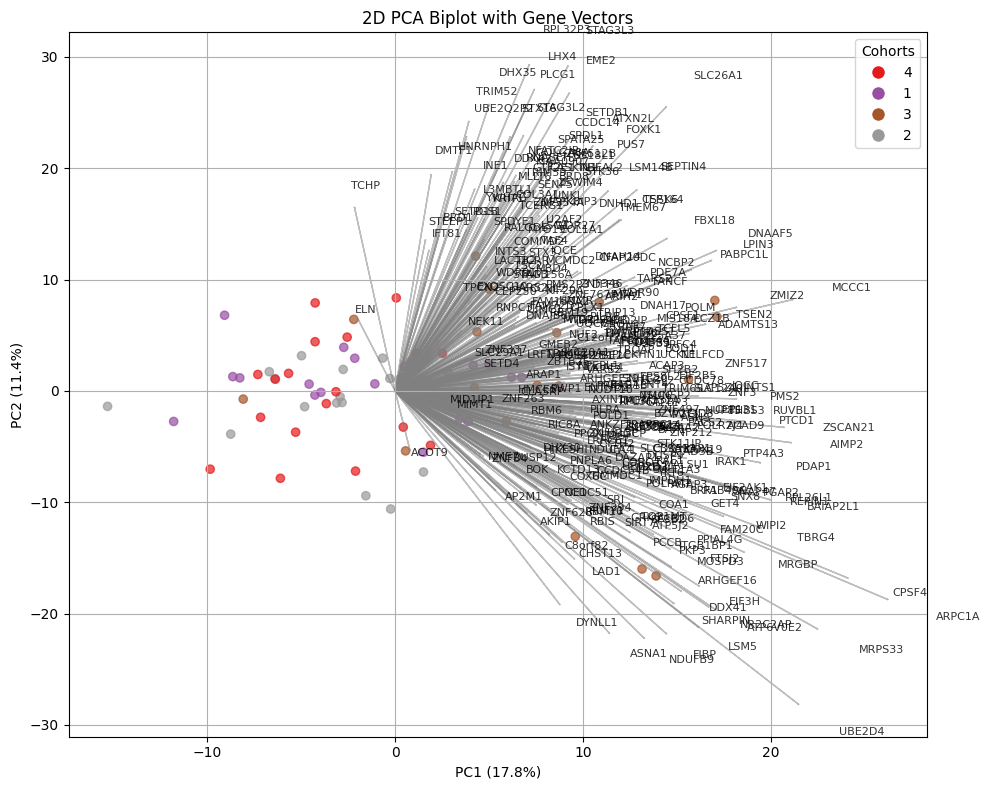

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Run PCA on the transposed data (samples as rows)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(parent_bchem_T_vals)

# Get variance explained
explained_var = pca.explained_variance_ratio_ * 100

# Get cohorts and assign high-contrast colors
cohorts = parent_bchem.columns
unique_labels = list(set(cohorts))
colormap = plt.cm.get_cmap("Set1", len(unique_labels))
color_map = {label: colormap(i) for i, label in enumerate(unique_labels)}
colors = cohorts.map(color_map)

# Plot 2D scatter plot with PCA results
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.7)

# Axis labels
ax.set_xlabel(f'PC1 ({explained_var[0]:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_var[1]:.1f}%)')
ax.set_title('2D PCA Biplot with Gene Vectors')

# Add gene vectors (loadings)
loadings = pca.components_.T  # shape: (n_genes, 2)
genes = parent_bchem_T.columns  # gene names

# Scale vectors for visibility
scale_factor = 200

for i, gene in enumerate(genes):
    ax.arrow(0, 0, 
             loadings[i, 0] * scale_factor, 
             loadings[i, 1] * scale_factor, 
             color='gray', alpha=0.5, head_width=0.05)
    ax.text(loadings[i, 0] * scale_factor * 1.1, 
            loadings[i, 1] * scale_factor * 1.1, 
            gene, fontsize=8, alpha=0.8)

# Custom legend
legend_patches = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, 
               markersize=10, markerfacecolor=color)
    for label, color in color_map.items()
]
ax.legend(handles=legend_patches, title='Cohorts', loc='best')

plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
print(len(parent_bchem.columns))

# print the top 10 genes that contribute to pc1

# Get the loadings for PC1
pc1_loadings = pca.components_[0]

# Create a DataFrame with genes and their corresponding loadings
pc1_contributions = pd.DataFrame({
    'Gene': parent_bchem_T.columns,
    'Contribution': pc1_loadings
})

# Sort by absolute contribution and get the top 10 genes
top_10_genes = pc1_contributions.reindex(pc1_contributions.Contribution.abs().sort_values(ascending=False).index).head(10)

print(top_10_genes)


74
         Gene  Contribution
13     ARPC1A      0.131033
73      CPSF4      0.120413
159    MRPS33      0.112366
284    UBE2D4      0.107338
153     MCCC1      0.105700
7       AIMP2      0.105250
316   ZSCAN21      0.103372
23   BAIAP2L1      0.099694
258     TBRG4      0.097274
180     PDAP1      0.097083


2025-06-27 20:12:00,381 [WARNING] Duplicated values found in preranked stats: 6.76% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Term,tag %,gene %,fdr,es,nes,lead_genes
0,onc_2024.gmt__ESC_V6.5_UP_EARLY.V1_DN,64/150,26.15%,0.027344,-0.386070,-1.635672,BCL3;CDC42EP1;CALML4;NAB2;HES7;PCOLCE;LOXL1;CCDC80;SOCS3;FHL2;ANXA5;SERPINE1;COL16A1;STARD8;SMARCD3;SERPINF2;TNC;ZFP36L1;FGF2;NID1;BHLHE40;ESRRA;JUNB;TUBB6;S100A6;CSRP1;IGFBP7;GSTP1;HTRA1;ANXA2;MGP;TFEB;GJB5;GJB3;SCARA3;FGF17;HBEGF;CAV1;TAGLN;KLK10;AEBP1;C16orf74;AXL;LAMC2;EMP1;NTN1;TGFB1I1;CADPS;ANXA3;BGN;SERPINF1;ANXA1;TIMP2;COL4A1;CARD14;PLCL2;ALX3;PMP22;GAP43;TGM1;KIT;S100A4;AQP3;UBD
1,onc_2024.gmt__RPS14_DN.V1_DN,59/177,18.05%,0.034033,0.388567,1.632869,ATAD2;THEM6;PRC1;KIF2C;KIF15;MKI67;CCNB2;TK1;KIF23;TUBGCP4;NUP155;ESPL1;KIF20A;LARS2;GTF2H4;INCENP;ECT2;AGAP1;DLGAP5;ERCC6L;MCM5;CENPE;PLK1;GINS2;USP5;CAD;MYH10;SLC29A2;NDC1;MTPAP;PBK;POLD1;TMSB15A;ARHGAP11A;LGR4;ZWILCH;COBLL1;PYCR1;MYO19;FBXO5;MSH2;MANEA;SLC31A1;NCAPH;MYBL2;PRMT3;MCM10;PSAT1;E2F8;DOCK9;SLC29A1;KCTD20;ASNS;APOBEC3A;EXO1;PC;EPCAM;MYLIP;EPB41
2,onc_2024.gmt__EIF4E_DN,29/90,15.01%,0.035096,0.402288,1.548132,ESRP1;TPD52;MYO10;NPEPPS;STRBP;FXR1;LRBA;EP400;SGPP2;SCAMP1;TP53BP1;IL36G;FRMD4B;MYH10;WDFY3;NCOA6;DIP2B;PRRC2C;TRIP11;CYP1B1;CLINT1;ADAM9;CTSC;EPDR1;PLEKHA5;DCTN4;APPBP2;CLTC;MMP9
3,onc_2024.gmt__AKT_UP.V1_DN,60/179,18.30%,0.036458,-0.373466,-1.637317,GNA14;RMND1;G6PC2;STMP1;SIX5;EXOSC1;C11orf71;C1R;ESR2;EFEMP2;ASS1;CNN2;SMARCD3;ADHFE1;SERPINF2;PDLIM3;GALNT16;ZDHHC6;UPB1;CAV2;CSDC2;ISLR;NID1;SNHG6;C1S;MSRB2;LTC4S;HIC1;KRT5;STAT5A;DPT;TSPAN4;ITIH5;HTRA1;FMO3;PDIA5;NAT8;CDPF1;ID3;RPS6KB2;GHR;CHST12;RECK;IFFO1;S1PR3;TIMP3;KLF2;MATN2;HPS1;SCARA3;TNS2;OGN;CD248;COL17A1;KRT15;FAH;AQP5;FAS;GSTA4;ZFYVE21
4,onc_2024.gmt__E2F1_UP.V1_UP,68/173,22.48%,0.037375,0.358794,1.526185,SMC2;TPD52;PRC1;RRM1;CHAF1B;MED20;TK1;WDHD1;TFAM;LPIN2;UBE2T;PKP4;BUB1;SLC35E1;TRNT1;DLGAP5;EZH2;MAP3K3;PLK4;MXI1;STIL;MAPK14;CAD;AGO2;POLA2;TYMS;TOP2A;ARF3;MSH3;AURKB;MCM4;PITPNM1;ADCY6;ARHGAP39;KIFC1;KIF2A;SLC7A1;CASP7;PHF12;NCAPH;ADIPOR2;PAIP2B;MCM10;TBP;VEGFA;TRAF3;LARP4B;E2F8;KPNA1;FEN1;RRP1B;CDV3;USP10;LMNB1;RB1;ERMP1;TLE4;ERCC2;TYRO3;DDB1;CNIH2;EIF6;UBR2;WBP11;DDX46;DCTPP1;UCK2;BRCA2
5,onc_2024.gmt__GCNP_SHH_UP_EARLY.V1_UP,53/161,18.62%,0.038287,0.410025,1.658527,AZIN1;AURKA;TRAIP;SMC2;PRC1;RRM1;FAM220A;TOP2B;VPS4B;CXorf38;RPL39L;PHTF2;KIF4A;UBE2T;VHL;CD276;EPB41L4B;SLC35E1;MSH6;PDS5B;MCM5;KIF1A;KIF1B;ANLN;TSHB;CDC23;FNTB;MAPK14;STAG2;POLA2;TYMS;TOP2A;AURKB;UPF3B;MCM6;SPDL1;ADCY6;FOXK1;KIFC1;CLCN6;MCM10;RYK;TBP;XPO1;E2F8;FEN1;PARG;TMPRSS2;GNL3;PUM2;LUC7L2;RNF103;ZNF708
6,onc_2024.gmt__TBK1.DN.48HRS_UP,31/49,24.75%,0.038287,0.536237,1.736433,PTK2;UBQLN2;COPB2;DDR1;MTFR1;OXSR1;SDHB;MAP3K4;TP53BP1;TEX10;CNOT4;PIK3C2B;APPBP2;PSRC1;RBM15B;P4HTM;SLC11A2;CNDP2;RNMT;ZMIZ1;IGFBP3;TMCO1;TM9SF2;CHMP6;LBR;ARL4C;UBE2J1;MYCBP;BAMBI;APOE;UGDH
7,onc_2024.gmt__TBK1.DF_DN,99/264,21.92%,0.039563,0.373576,1.564174,ATP6V1C1;ZC2HC1A;ZWINT;CCNE2;RSRC1;CXADR;KTN1;TCAF1;UBL4A;TBC1D10B;TFAM;KDM4A;KIF3A;MPHOSPH9;PKP4;ATG2B;KPNA6;PRRC2B;GOLGA2;UBE2W;RBBP5;GTPBP8;SLC25A13;MED13L;MFSD6;ZNF654;ERLIN2;GALNT3;GALNT11;SCARB1;KIF14;IDE;CDCA4;ANKFY1;ARMC1;PANK3;PDHX;GTF2A1;GNAI3;RXRA;MTPAP;GNPDA1;ADAM10;CLEC16A;DNAJC16;NME6;YES1;ZNF557;NAA15;BPTF;CD2AP;SEMA3C;TBK1;RCBTB1;SPDL1;FNBP1L;UBXN4;ADCY6;MAOA;ATP6AP2;MSH2;C5orf22;OSBPL1A;ALDH9A1;NF1;HMGCS1;RSF1;MBP;SMARCA2;LETM1;EXOC5;RALA;ZNHIT6;TSPAN5;SIKE1;RNF5;SOWAHC;NAA35;BACH1;DNAJB14;SUSD6;ITCH;USP46;SNX15;DDX60;SMURF2;LMNB1;SLC35A5;USP22;TTPAL;RFWD3;NRIP1;MIS18BP1;GOLGA4;EHF;AGFG1;THOC2;PMAIP1;CLOCK
8,onc_2024.gmt__GCNP_SHH_UP_LATE.V1_UP,46/168,16.47%,0.039882,0.369529,1.509909,AURKA;CDC25C;SMC2;PRC1;RRM1;KIF2C;TOP2B;VPS4B;TK1;CDK1;PHTF2;RRM2;INCENP;DLGAP5;MCM5;COPB1;GALNT3;SMC4;PLEKHA7;POLA2;FANCC;NUSAP1;TOP2A;UNG;GART;AURKB;NAA15;MCM4;MCM6;SACM1L;SDC2;LIG1;KIFC1;PTCD3;EIF3A;GFM2;CLCN5;MCM10;RYK;ARIH1;XPO1;PIK3CA;E2F8;SLC29A1;FOXA1;PCNT
9,onc_2024.gmt__CRX_DN.V1_DN,29/119,13.71%,0.046875,-0.411467,-1.684848,BCL3;LAD1;NAB2;PCOLCE;CEBPB;MYOCD;SOCS3;TECTA;SMOC2;CEBPD;COL16A1;SERPING1;CAMK2B;TMOD1;SPG21;JUNB;TUBB6;S100A6;EGR1;GNG11;FMO3;ANXA2;KLF10;TIMP1

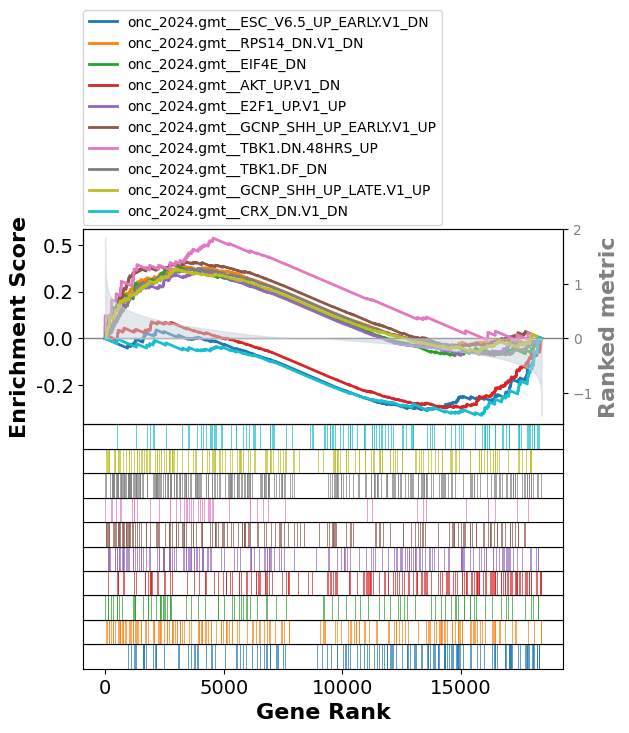

In [69]:
# Create a ranking metric - here using the difference between c4 and c1 averages
expression['ranking_metric'] =  expression['c1 Average'] - expression['c4 Average']

# Rank genes by this metric
ranking = expression[['ranking_metric']]
ranking = ranking.sort_values(by='ranking_metric', ascending=False)

# Convert to the format gseapy expects (index = gene names, column = ranking)
ranking = ranking.rename_axis("gene").reset_index()

import gseapy as gp

# Path to the gene sets file
gmt_file = "data/hallmark_2024.gmt"  # Update path as needed

pre_res = gp.prerank(rnk = ranking,
                     gene_sets=["data/onc_2024.gmt"], # kegg is a dict object
                     seed = 6, permutation_num = 100)

# gene_sets=["data/bp_2024.gmt", "data/cc_2024.gmt", "data/mf_2024.gmt", "data/hallmark_2024.gmt", "data/onc_2024.gmt", "data/im_2024.gmt"], # kegg is a dict object

out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['tag %'],
               pre_res.results[term]['gene %'],
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes'],
               pre_res.results[term]['lead_genes']])

out_df = pd.DataFrame(out, columns = ['Term', 'tag %', 'gene %', 'fdr', 'es', 'nes', 'lead_genes']).sort_values('fdr').reset_index(drop = True)
# display(HTML(out_df.to_html()))

axs = pre_res.plot(out_df['Term'][0:10],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

display(HTML(out_df.to_html()))


2025-06-27 20:12:04,470 [WARNING] Found duplicated gene names, values averaged by gene names!


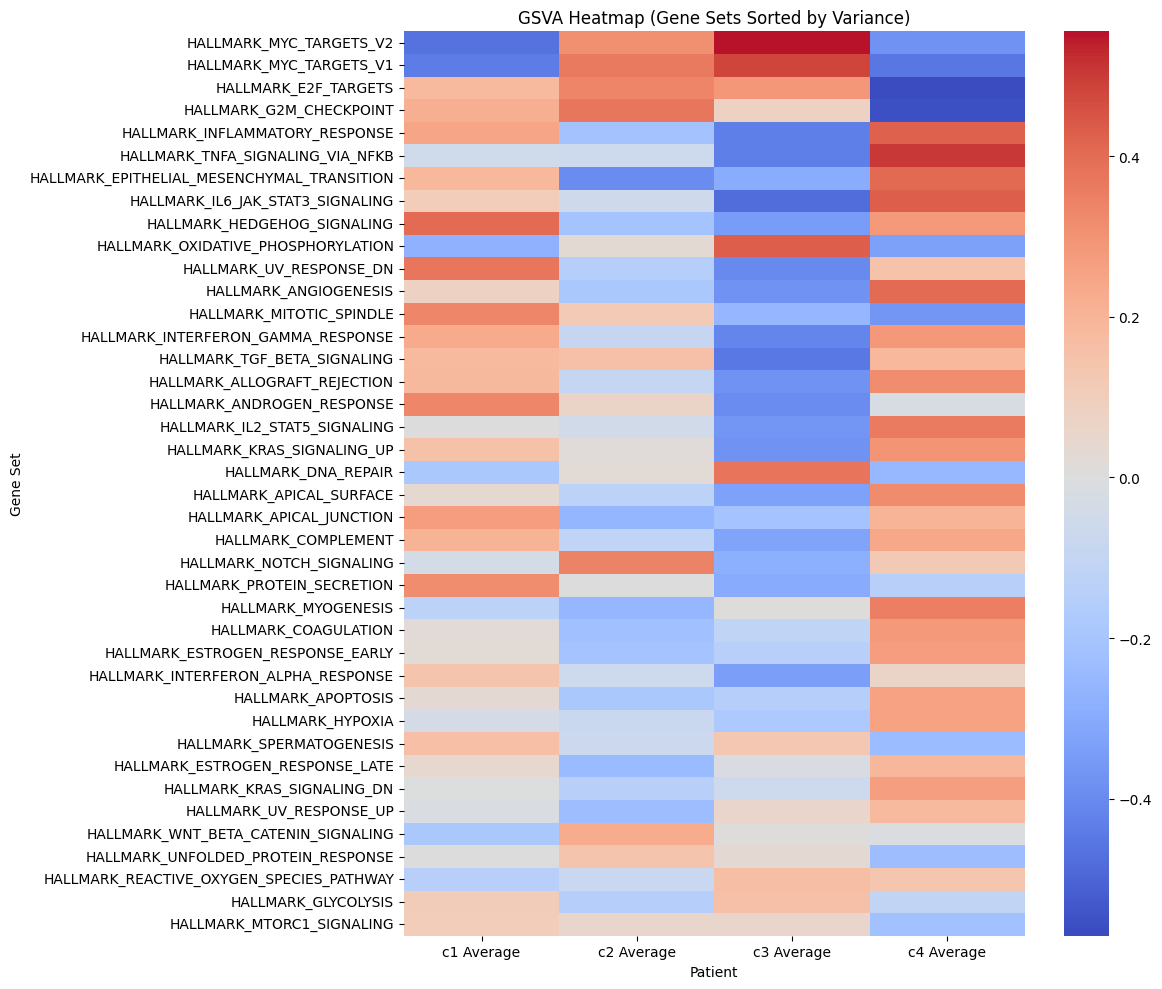

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gseapy as gp

# Drop metadata
original_expression = expression.drop(columns=["Cluster", "ranking_metric"])

# Run GSVA
es = gp.gsva(data=original_expression,
             gene_sets='data/hallmark_2024.gmt',
             outdir=None)

# Pivot to gene sets × patients matrix
es_matrix = es.res2d.pivot(index='Term', columns='Name', values='ES')

# Convert to float and drop NaNs just in case
es_matrix = es_matrix.astype(float).dropna(axis=0, how='any')

# Sort gene sets by row variance
es_matrix['Variance'] = es_matrix.var(axis=1)
es_matrix_sorted = es_matrix.sort_values(by='Variance', ascending=False).drop(columns='Variance')
top_n = 40
es_matrix_sorted = es_matrix_sorted.head(top_n)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(es_matrix_sorted, cmap='coolwarm', center=0)
plt.title("GSVA Heatmap (Gene Sets Sorted by Variance)")
plt.xlabel("Patient")
plt.ylabel("Gene Set")
plt.tight_layout()
plt.show()


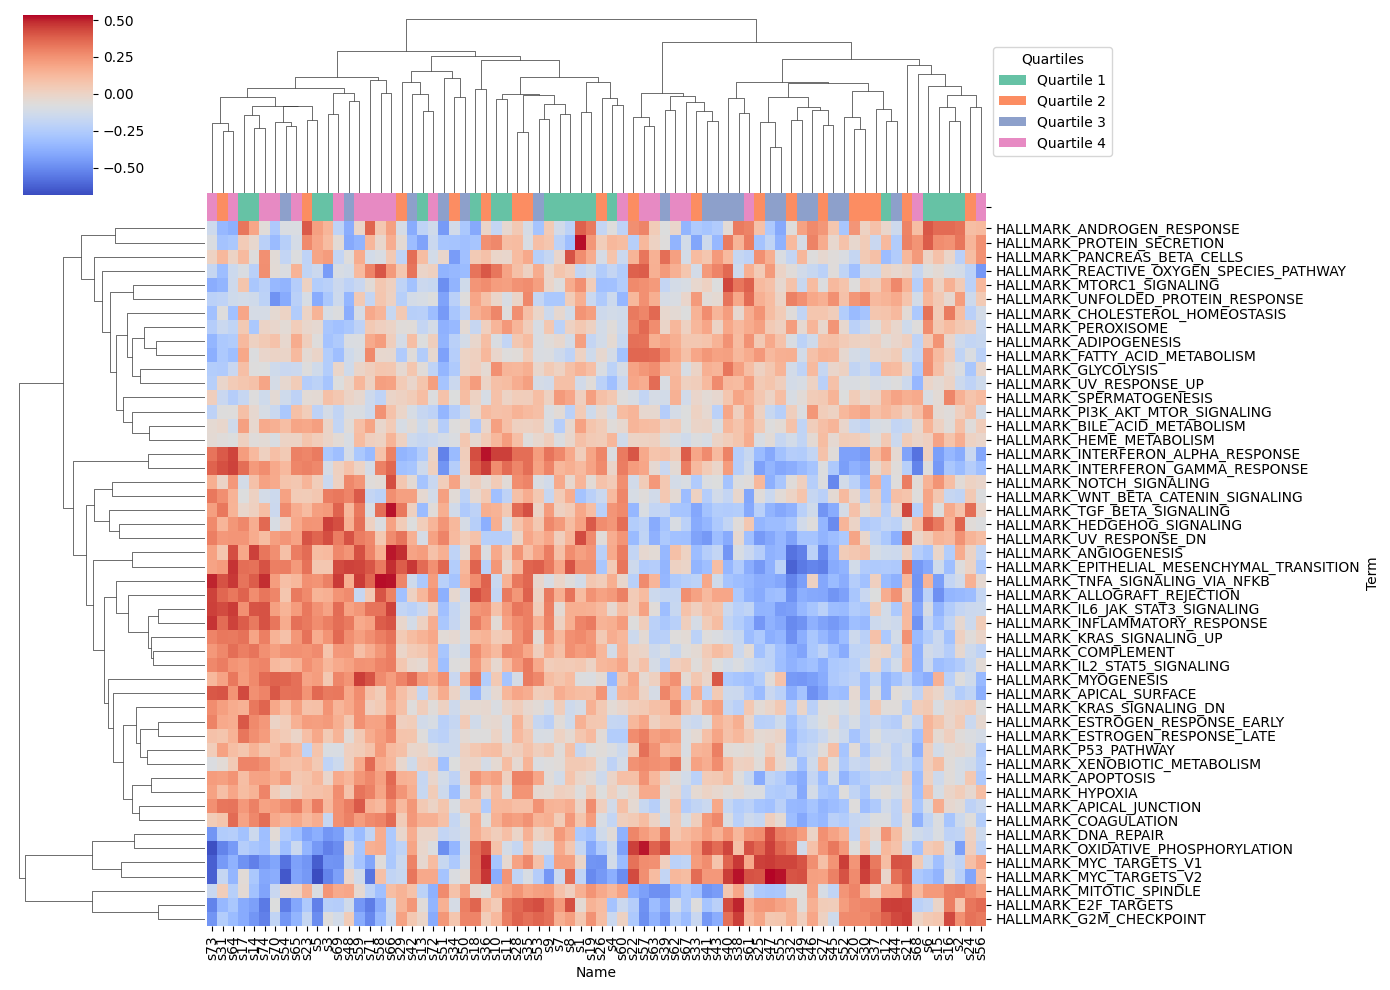

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import gseapy as gp

# Step 1: Rename columns to s1, s2, ..., sN
parent_bchem.columns = [f's{i+1}' for i in range(parent_bchem.shape[1])]

# Step 2: Create list of quartile labels matching sample order
# Assuming adjusted_c1 to adjusted_c4 were defined before and concatenated in that order:
quartile_labels = [1] * adjusted_c1.shape[1] + \
                  [2] * adjusted_c2.shape[1] + \
                  [3] * adjusted_c3.shape[1] + \
                  [4] * adjusted_c4.shape[1]

# Make sure length matches columns
assert len(quartile_labels) == parent_bchem.shape[1], "Mismatch in sample and quartile count!"

# Step 3: Map quartile labels to colors
quartile_palette = sns.color_palette("Set2", 4)
quartile_color_map = dict(zip([1, 2, 3, 4], quartile_palette))
col_colors = pd.Series(quartile_labels, index=parent_bchem.columns).map(quartile_color_map)

# Step 4: Run GSVA (deduplicate first if needed)
parent_bchem = parent_bchem.groupby(parent_bchem.index).mean()

gsva_results = gp.gsva(data=parent_bchem,
                       gene_sets='data/hallmark_2024.gmt',
                       outdir=None)

# Step 5: Pivot GSVA result and convert to matrix
es_matrix = gsva_results.res2d.pivot(index='Term', columns='Name', values='ES')
es_matrix = es_matrix.astype(float).dropna(axis=0, how='any')

# Step 6: Plot clustermap with quartile annotations
g = sns.clustermap(
    es_matrix,
    cmap="coolwarm",
    xticklabels=True,
    yticklabels=True,
    annot=False,
    row_cluster=True,
    col_cluster=True,
    col_colors=col_colors,
    figsize=(14, 10)
)

# Add quartile legend
legend_elements = [
    Patch(facecolor=quartile_color_map[q], label=f'Quartile {q}') for q in sorted(quartile_color_map)
]
g.ax_col_dendrogram.legend(
    handles=legend_elements,
    title='Quartiles',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)

plt.show()


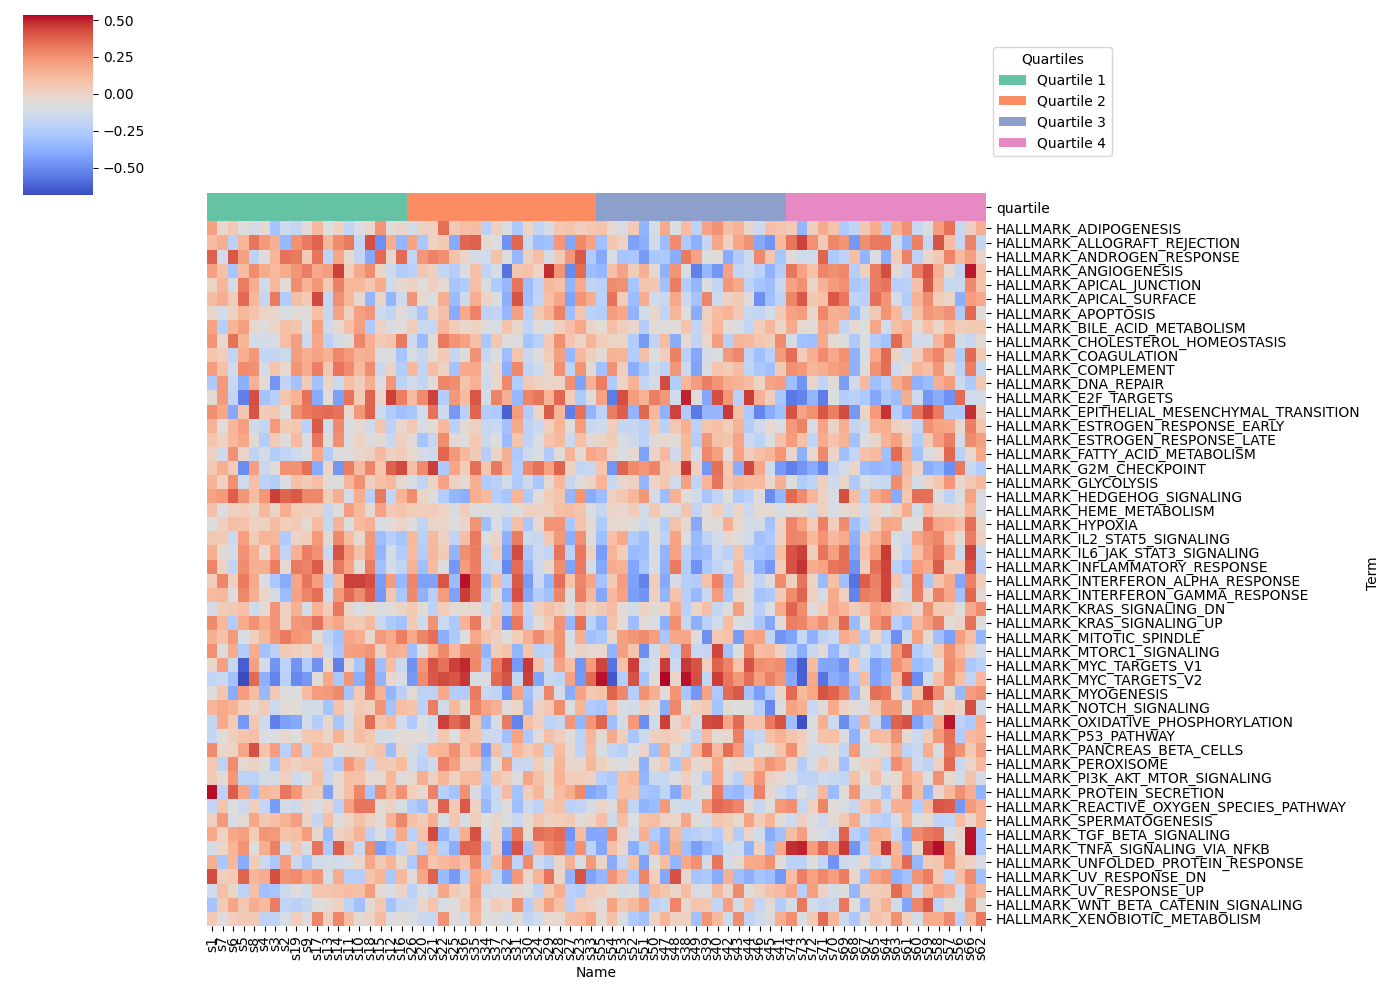

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import gseapy as gp

# Step 1: Rename columns to s1, s2, ..., sN
parent_bchem.columns = [f's{i+1}' for i in range(parent_bchem.shape[1])]

# Step 2: Generate quartile labels
quartile_labels = [1] * adjusted_c1.shape[1] + \
                  [2] * adjusted_c2.shape[1] + \
                  [3] * adjusted_c3.shape[1] + \
                  [4] * adjusted_c4.shape[1]

# Map quartiles to colors
quartile_palette = sns.color_palette("Set2", 4)
quartile_color_map = dict(zip([1, 2, 3, 4], quartile_palette))
quartile_series = pd.Series(quartile_labels, index=parent_bchem.columns, name="quartile")
col_colors = quartile_series.map(quartile_color_map)

# Step 3: Deduplicate genes
parent_bchem = parent_bchem.groupby(parent_bchem.index).mean()

# Step 4: Run GSVA
gsva_results = gp.gsva(data=parent_bchem,
                       gene_sets='data/hallmark_2024.gmt',
                       outdir=None)

# Step 5: Extract GSVA matrix
es_matrix = gsva_results.res2d.pivot(index='Term', columns='Name', values='ES')
es_matrix = es_matrix.astype(float).dropna(axis=0, how='any')

# Step 6: Reorder columns by quartile
quartile_df = pd.DataFrame({
    "sample": es_matrix.columns,
    "quartile": quartile_series[es_matrix.columns].values
})
ordered_samples = quartile_df.sort_values("quartile")["sample"].tolist()

# Reorder matrix and colors
es_matrix = es_matrix[ordered_samples]
col_colors = col_colors[ordered_samples]

# Step 7: Plot WITHOUT clustering
g = sns.clustermap(
    es_matrix,
    cmap="coolwarm",
    xticklabels=True,
    yticklabels=True,
    annot=False,
    row_cluster=False,
    col_cluster=False,
    col_colors=col_colors,
    figsize=(14, 10)
)

# Step 8: Add quartile legend
legend_elements = [
    Patch(facecolor=quartile_color_map[q], label=f'Quartile {q}') for q in sorted(quartile_color_map)
]
g.ax_col_dendrogram.legend(
    handles=legend_elements,
    title='Quartiles',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)

plt.show()
